In [1]:
import krakenex
import pandas as pd
import matplotlib.pyplot as plt
from requests.exceptions import HTTPError

In [25]:
kraken = krakenex.API()

In [154]:
def get_order_book(pair, count):
    """Queries the kraken order book.

    Parameters
    ----------
    pair : str 
        Asset pair to get market depth for.
    count : int 
        Maximum number of asks/bids
    df : bool
        Weather to return order book as dataframe (optional).

    Returns
    -------
    dict
        asks : list
            Ask side array of (<price>, <volume>, <timestamp>).
        bids : list 
            Bid side array of (<price>, <volume>, <timestamp>).
    """
    
    try:
        response = kraken.query_public('Depth', {'pair': pair, 'count': count})
    except HTTPError as e:
        print("ERROR: Failed getting order book data for pair={}".format(pair))
    
    obook = response.get('result', {}).get(pair)
    if not obook:
        print("WARNING: Empty response.")
    else:
        asks = [limorder + ['ask'] for limorder in obook['asks']]
        bids = [limorder + ['bid'] for limorder in obook['bids']]
        tabular = asks + bids
        obook = pd.DataFrame(tabular, columns=['price', 'volume', 'timestamp', 'type'])            
        obook = obook.apply(pd.to_numeric, errors='ignore')
        obook['cumvolume'] = obook[['type', 'volume']].groupby('type').cumsum()  # assumes rows are sorted
        
    return obook


def plot_order_book(ob):
    """Plots the cumulative volume and order distribution of the order book.
    
    Paramaters
    ----------
    ob : dataframe
        Order book data frame with columns type, price, volume, cumvolume.
    """
    
    # extract data series from df
    ask_prices = ob.loc[ob['type'] == 'ask', 'price']
    ask_volumes = ob.loc[ob['type'] == 'ask', 'volume']
    ask_cumvolumes = ob.loc[ob['type'] == 'ask', 'cumvolume']
    bid_prices = ob.loc[ob['type'] == 'bid', 'price']
    bid_volumes = ob.loc[ob['type'] == 'bid', 'volume']
    bid_cumvolumes = ob.loc[ob['type'] == 'bid', 'cumvolume']
    
    # plot cum vol plot
    fig, ax = plt.subplots(2, 1, sharex='col', figsize=(16, 10))
    ax[0].fill_between(bid_prices, bid_cumvolumes, facecolor='maroon', edgecolor='k', alpha=0.7, zorder=10, label='bids')
    ax[0].fill_between(ask_prices, ask_cumvolumes, facecolor='dimgrey', edgecolor='k', alpha=0.7, zorder=10, label='asks')
    ax[0].set_xlim([min(bid_prices.min(), ask_prices.min()), max(bid_prices.max(), ask_prices.max())])
    ax[0].set_ylim([0, 1.05* max(bid_cumvolumes.max(), ask_cumvolumes.max())])
    ax[0].set_ylabel('Cumulative Volume')
    ax[0].legend(loc='upper center', facecolor='white', framealpha=1, frameon=False)
    
    # plot order distribution
    ax[1].stem(bid_prices, bid_volumes, 'maroon', markerfmt=' ', label='bids')
    ax[1].stem(ask_prices, ask_volumes, 'k', markerfmt=' ', label='asks')
    ax[1].set_ylim([0, 1.05* max(bid_volumes.max(), ask_volumes.max())])
    ax[1].set_xlabel('Price')
    ax[1].set_ylabel('Volume')
    
    plt.show()

In [155]:
ob = get_order_book('XXRPZEUR', 100)
ob.head()

,price,volume,timestamp,type,cumvolume
0,0.27770,331.619,1552264394,ask,331.619
1,0.27779,2724.105,1552264390,ask,3055.724
2,0.27780,3602.698,1552264347,ask,6658.422
3,0.27786,2056.326,1552264372,ask,8714.748
4,0.27789,1777.260,1552264394,ask,10492.008


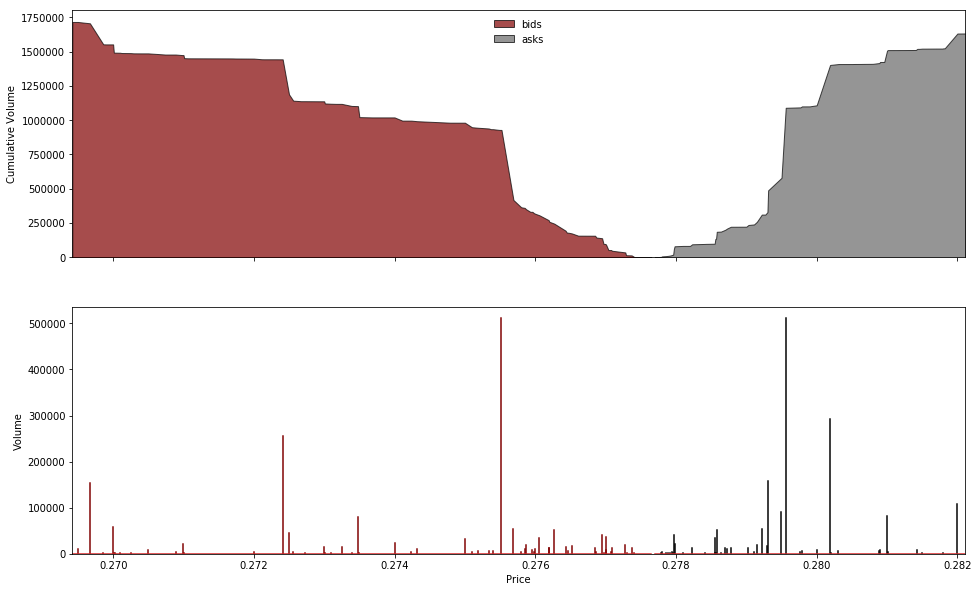

In [156]:
plot_order_book(ob)